# Climate feedback

In [1]:
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
from typhon import plots

import konrad


plots.styles.use()

## Regression method

Compute the climate feedback as regression of the radiation balance over the surface temperature change {cite:p}`gregory04`.

In [2]:
phlev = konrad.utils.get_quadratic_pgrid(1000e2, 10, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)

# Initialize the setup for the radiative-convective equilibrium simulation.
spinup = konrad.RCE(
    atmosphere,
    surface=konrad.surface.FixedTemperature(temperature=295.0),
    timestep='24h',  # Set timestep in model time.
    max_duration='150d',  # Set runtime.
    outfile='spinup.nc',  # Specify output filename.
)
spinup.run()  # Start the simulation.

atmosphere["CO2"][:] *= 2.0 # double the CO2 concentration

perturbed = konrad.RCE(
    atmosphere,
    surface=konrad.surface.SlabOcean(
        temperature=295.0,
        heat_sink=spinup.radiation["toa"][-1],
        depth=10.,
    ),
    timestep='12h',  # Set timestep in model time.
    max_duration='300d',  # Set runtime.
    outfile='perturbed.nc',  # Specify output filename.
)
perturbed.run()  # Start the simulation.

Climate feedback: -1.143 W/m^2/K


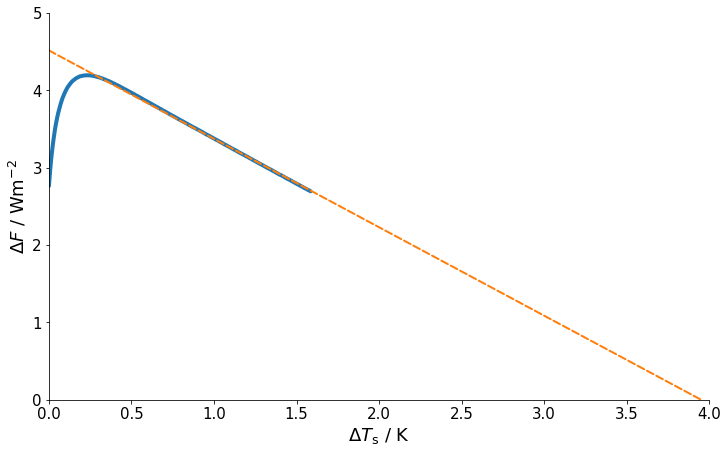

In [3]:
with netCDF4.Dataset("perturbed.nc", "r") as root:
    Ts = root["surface/temperature"][:]
    olr = root["radiation/toa"][:] - root["surface/heat_sink"][0]

fig, ax = plt.subplots()
ax.plot(Ts - Ts[0], olr, lw=4)
p = np.polyfit(Ts[25:] - Ts[0], olr[25:], deg=1)
ax.axline((0, p[1]), slope=p[0], ls="dashed", color="tab:orange")
ax.set_xlabel(r"$\Delta T_\mathrm{s}$ / K")
ax.set_ylabel(r"$\Delta F$ / $\rm Wm^{-2}$")
ax.set_xlim(0, 4)
ax.set_ylim(0, 5)

print(f"Climate feedback: {p[0]:.3f} W/m^2/K")

## Fixed temperature method

In [4]:
phlev = konrad.utils.get_quadratic_pgrid(1000e2, 10, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)

cold = konrad.RCE(
    atmosphere,
    surface=konrad.surface.FixedTemperature(temperature=295.0),
    timestep='24h',  # Set timestep in model time.
    max_duration='150d',  # Set runtime.
)
cold.run()  # Start the simulation.

warm = konrad.RCE(
    atmosphere,
    surface=konrad.surface.FixedTemperature(temperature=297.0),
    timestep='24h',  # Set timestep in model time.
    max_duration='150d',  # Set runtime.
)
warm.run()  # Start the simulation.

feedback = (
    (warm.radiation["toa"][-1] - cold.radiation["toa"][-1]) /
    (warm.surface["temperature"][-1] - cold.surface["temperature"][-1])
)

print(f"Climate feedback: {feedback:.3f} W/m^2/K")

Climate feedback: -1.176 W/m^2/K
